# 1. Выбор метрики

## 1.1. Предисловие

Как оценить, справляется ли наша рекомендательная система с поставленной задачей? Рекомендует ли она те фильмы, которые будут интересны пользователю? Насколько хорошо она понимает пользователя?

Для ответа на данные вопросы применяются различные метрики для оценки эффективности рекомендательной системы.  
Например, nDCG, AUC, Precision@k и Recall@k, обычные Precision и Recall и другие. У каждой из них есть свои плюсы и минусы.  
В рамках решения данной задачи мне необходимо было выбрать метрику, которая, как мне кажется, наилучшим образом демонстрирует точность работы рекомендательной системы.

## 1.2. Формализация задачи

В рамках исходного задания об исследовании двух подходов к построению рекомендательных систем я формализовал задачу так: необходимо построить рекомендательную систему, которая, на основании известных данных о предыдущих оценках фильмов пользователем, способна рекомендовать фильмы, которые будут высоко оценены пользователем. Оценки находятся в промежутке от 0 до 5, высокими будем называть оценки >=4.

Таким образом, формализованная задача является задачей бинарной классификации: для каждого фильма, не просмотренного пользователем, необходимо определить, поставил бы пользователь высокую или низкую оценку данному фильму. 

## 1.3. Метрика

Для оценки точности работы модели в рамках задачи бинарной классификации наиболее показательной метрикой, на мой взгляд, является метрика **AUC** - **A**rea **U**nder **C**urve, где curve - это ROC кривая.    

ROC кривая демонстрирует соотношение True Positive и False Positive в зависимости от выбора порога решающего правила. 

Анализ ROC кривой позволит нам, на практике, самостоятельно выбрать значение порога, в зависимости от наших целей.  
Например, если мы не хотим рисковать, рекомендуя пользователю фильмы, которые могут ему не понравиться, мы можем установить значение порога достаточно высоким. Или же, наоборот, если нам важнее количество, а не качество рекомендаций, то порог можно понизить.
Таким образом, ROC-кривая позволяет получить информацию о точности и ее зависимости от порога решающего правила.

Метрика **AUC** широко используется для сравнения точности моделей на основании ROC кривой и позволит нам сравнить построенные модели рекомендательных систем.

In [1]:
from sklearn.metrics import roc_auc_score

## 1.4. Другие метрики

При другой формализации задачи (например, при построении модели, аппроксимирующей оценки пользователей от 0 до 5), возможно, **AUC** был бы не лучшей метрикой, и вместо нее можно было бы взять метрику для оценки точности ранжирования nDCG.

# 2. Разбиение данных на обучение и валидацию

В рамках формализованной задачи вижу несколько способов разбиения датасета на train и test.  
 
Для составления test можно выделить:
1. Определенный процент оцененных фильмов для каждого пользователя;
2. Определенное количество оцененных фильмов для каждого пользователя;
3. Определенное количество пользователей со всеми их оценками.

Каждый подход обладает своими преимуществами и недостатками.  

Первый подход в целом неплох, однако он не слишком хорошо подходит для выбранной метрики, поскольку размеры списков предсказываемых оценок будут сильно различаться. Например, для пользователя с 20-ю оценками, необходимо будет рассчитывать метрику на 4-х фильмах (при выборе test_size 20%), а для пользователя с 1000 - на двухстах. Важность построенного AUC для каждого пользователя, конечно, можно сопоставить с размером его тестовой выборки, добавив весовой коэффициент, однако это вносит дополнительные трудности в расчет метрики.  

Второй подход в этом плане лучше, поскольку при фиксированном количестве необходимых к оценке фильмов мы получаем уже взвешенную метрику AUC. Кроме того, такое разбиение позволит оценить, насколько, в среднем, рекомендательная система "понимает" интересы пользователей с разным количеством оцененных фильмов. На мой взгляд, это наилучший вариант.

Третий подход также неплох, однако для реализации потребуется вводить дополнительную логику, чтобы предсказывать фильмы для пользователей, чьи оценки не учитывались на этапе обучения модели. Такой подход привлекателен с практической точки зрения. Он отвечает на вопрос, насколько хорошо мы можем рекомендовать фильмы совершенно новым пользователям. Однако, его реализация значительно затрудняет процесс оценки эффективности самих моделей, что идет в разрез с тестовым заданием - сравнить коллаборативный и гибридный подходы.

В итоге, был выбран второй подход.  
Для каждого пользователя из датасета мы будем брать последние 10 оцененных им фильмов и убирать их из обучающего датасета, чтобы в последствии тестировать модели на них.

# 3. Обработка базы данных (коллаборативный подход)

## 3.0. Подготовка к работе

In [2]:
import os, zipfile

file_name = 'archive.zip'
archive_dir = "archive"
data_dir = "data"


if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
if not os.path.exists(archive_dir):
    os.mkdir(archive_dir)

if file_name not in os.listdir():
    raise Exception("Пожалуйста, скачайте датасет (https://www.kaggle.com/grouplens/movielens-20m-dataset) и поместите его в одну папку с ноутбуком")
else:    
    zip_ref = zipfile.ZipFile(file_name) # create zipfile object
    zip_ref.extractall(archive_dir) # extract file to dir
    zip_ref.close() # close file

## 3.1. Загрузка таблицы rating.csv

In [3]:
import os
os.listdir("archive/")

['genome_scores.csv',
 'genome_tags.csv',
 'link.csv',
 'movie.csv',
 'rating.csv',
 'tag.csv']

In [4]:
import numpy as np
import pandas as pd

rating_df = pd.read_csv("archive/rating.csv", parse_dates=["timestamp"])
rating_df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [5]:
print(f"{rating_df.userId.nunique()}\tУникальных пользователей\n{rating_df.movieId.nunique()}\tУникальных фильмов")

138493	Уникальных пользователей
26744	Уникальных фильмов


## 3.2. Анализ rating.csv

Из описания к датасету ясно, что каждый пользователь оценил как минимум 20 фильмов. Однако, в описании нет информации о том, сколько раз был оценен каждый фильм. Необходимо провести проверку.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
num_rated = rating_df.groupby("movieId").count().sort_values("userId", ascending=False).userId.values

Число уникальных фильмов:  26744


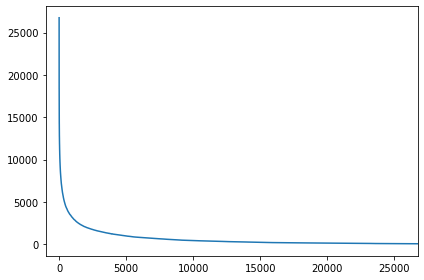

In [8]:
print("Число уникальных фильмов: ",len(num_rated))
fig, ax = plt.subplots()
ax.set_xlim(xmin=-1000, xmax=len(num_rated))
ax.plot(num_rated, range(len(num_rated)))

fig.tight_layout()
plt.show()

Как видим, большая часть фильмов имеет относительно небольшое количество оценок. Взглянем на распределение более детально 

In [9]:
rating_df.groupby("movieId").count().describe()

,userId,rating,timestamp
count,26744.000000,26744.000000,26744.000000
mean,747.841123,747.841123,747.841123
std,3085.818268,3085.818268,3085.818268
min,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000
50%,18.000000,18.000000,18.000000
75%,205.000000,205.000000,205.000000
max,67310.000000,67310.000000,67310.000000


25% фильмов были оценены не более 3-х раз, а 50% - не более 18.

Наличие фильмов с небольшим количеством оценок может негативно сказаться на работе моделей - они создают малопрогнозируемый шум. Кроме того, они значительно увеличивают объемы памяти, необходимые для работы с данными.

Для того, чтобы избежать потенциальных проблем, описанных выше, оставим в датасете только те фильмы, которые были оценены минимум 50 раз.

In [10]:
sum(num_rated>50)

10473

In [11]:
gr_df = rating_df.groupby("movieId").count()
ind = gr_df.loc[gr_df.userId>50].index
rating_df = rating_df.loc[rating_df.movieId.isin(ind)]
rating_df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


## 3.3. Нормализация оценок

Необходимо преобразовать "положительные" оценки больше или равные 4-м в единицы, а остальные - в минус один. 

In [12]:
rating_df["rating"] = rating_df.rating.apply(lambda x: 1 if x>=4 else -1)
rating_df

c:\users\roman-k\workplace\cuda_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,userId,movieId,rating,timestamp
0,1,2,-1,2005-04-02 23:53:47
1,1,29,-1,2005-04-02 23:31:16
2,1,32,-1,2005-04-02 23:33:39
3,1,47,-1,2005-04-02 23:32:07
4,1,50,-1,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,1,2009-11-13 15:42:00
20000259,138493,69526,1,2009-12-03 18:31:48
20000260,138493,69644,-1,2009-12-07 18:10:57
20000261,138493,70286,1,2009-11-13 15:42:24


## 3.4. Проверка UserId и MovieId на последовательность

Было бы удобно, если бы id фильмов и пользователей соответствовали своему порядковому номеру. Проведем проверку

In [13]:
sorted(rating_df.userId.unique()) == list(range(1, rating_df.userId.nunique()+1))

True

In [14]:
sorted(rating_df.movieId.unique()) == list(range(1, rating_df.movieId.nunique()+1))

False

Обнаружилась проблема в MovieId. Индексы фильмов идут не по порядку, пропуская значения, что может привести к проблемам с индексацией. Решено составить словари соответствий.

In [15]:
# Уникальные ID
ids = sorted(rating_df.movieId.unique())
# Словарь позиция-id
pos2id = {pos: i for pos, i in zip(range(1, len(ids)+1), ids)}
# Словарь id-позиция
id2pos = {i: pos for pos, i in zip(range(1, len(ids)+1), ids)}

Переведем movieId в таблице в новый формат

In [16]:
rating_df.movieId = rating_df.movieId.apply(lambda x: id2pos[x])
rating_df

c:\users\roman-k\workplace\cuda_env\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,userId,movieId,rating,timestamp
0,1,2,-1,2005-04-02 23:53:47
1,1,29,-1,2005-04-02 23:31:16
2,1,32,-1,2005-04-02 23:33:39
3,1,47,-1,2005-04-02 23:32:07
4,1,50,-1,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,9103,1,2009-11-13 15:42:00
20000259,138493,9130,1,2009-12-03 18:31:48
20000260,138493,9137,-1,2009-12-07 18:10:57
20000261,138493,9162,1,2009-11-13 15:42:24


## 3.5. Разделение датасета на train и test

На этапе постановки задачи было решено разделить исходную базу данных на обучающий и тестовый наборы данных следующим образом:  
  
1. Набор для тестирования - последние 10 оценок каждого пользователя;   
2. Набор для обучения - остальные оценки для каждого пользователя. 

Так как операция разделения ресурсозатратная (или я не нашел более оптимального решения), создадим для нее специальный метод с возможностью загрузки из памяти, если датасеты уже были созданы.  

In [17]:
# Отсортируем по id и времени 
rating_df = rating_df.sort_values(["userId", "timestamp"])
# И удалим столбец со временем - он больше не пригодится
rating_df.drop("timestamp", axis=1, inplace=True)

In [18]:
def split(df, train_name='train.csv', test_name='test.csv', path='data/', force=False):
    """
    Данный метод разделяет df на train и test(10 последних оценок), 
    """
    # Загрузка датасетов с диска, если они есть
    if (train_name in os.listdir(path) and test_name in os.listdir(path)) and not force:
        return pd.read_csv(path + train_name),\
               pd.read_csv(path + test_name)
    else:
        
        # Датасет с фильмами пользователя, которые будем пытаться угадать 
        test_df = df.groupby("userId").apply(lambda x: x.iloc[-10:])
        test_df = test_df.drop("userId", axis=1).reset_index().drop("level_1", axis=1)

        # Датасет с фильмами пользователя, по которым будем строить модели
        train_df = df.groupby("userId").apply(lambda x: x.iloc[:-10])
        train_df = train_df.drop("userId", axis=1).reset_index().drop("level_1", axis=1)
        
        # Сохраним датасеты
        train_df.to_csv(path + train_name, index=False)
        test_df.to_csv(path + test_name, index=False)
        
        return train_df, test_df

In [19]:
train_df, test_df = split(rating_df)

Проверим, все ли фильмы из изначального датасета попали в train_df

In [20]:
train_df.movieId.nunique() == rating_df.movieId.nunique()

True

# 4. Обработка базы данных (гибридный (коллаборативный+контентный) подход)

## 4.1. Информация о жанрах

Точность работы модели потенциально можно повысить, если принять во внимание свойства самих объектов - фильмов. В датасете, помимо названий фильмов и их оценок от пользователей, также содержится информация о жанрах, к которым принадлежит каждый фильм (movies.csv), а также тэгах и степени релевантности этих тэгов по отношению к фильмам (genome_scores.csv). Кроме того, в датасете присутствует таблица tag.csv, которая показывает, какие тэги отдельные пользователи назначали просмотренным фильмам.

Необходимо составить таблицу, содержащую в себе дополнительную информацию о фильмах. Для начала, возьмем информацию о жанрах фильмов.

In [21]:
os.listdir("archive/")

['genome_scores.csv',
 'genome_tags.csv',
 'link.csv',
 'movie.csv',
 'rating.csv',
 'tag.csv']

In [22]:
mv = pd.read_csv("archive/movie.csv")
mv

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


Удалим те фильмы, которые мы убрали из исходной таблицы, и переведем movieId в новый формат, согласно словарю id2pos

In [23]:
mv = mv.loc[mv.movieId.isin(list(id2pos.keys()))]
mv.movieId = mv.movieId.apply(lambda x: id2pos[x])
mv

c:\users\roman-k\workplace\cuda_env\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
25253,10469,The Interview (2014),Action|Comedy
25254,10470,Kingsman: The Secret Service (2015),Action|Adventure|Comedy|Crime
25258,10471,Night at the Museum: Secret of the Tomb (2014),Adventure|Children|Comedy|Fantasy
25490,10472,Taken 3 (2015),Action|Crime|Thriller


Создадим словарь соответствия уникальных жанров с их порядковым номером

In [24]:
genre_set = set([x for genre in mv.genres.unique() for x in genre.split("|")])
genre_dict = {genr: i for i, genr in zip(range(len(genre_set)), genre_set)}
genre_dict

{'Fantasy': 0,
 'Sci-Fi': 1,
 'Mystery': 2,
 'War': 3,
 'Animation': 4,
 'Musical': 5,
 'Children': 6,
 'Crime': 7,
 'Western': 8,
 'Documentary': 9,
 'Comedy': 10,
 'Thriller': 11,
 'Drama': 12,
 'Romance': 13,
 'Adventure': 14,
 'Horror': 15,
 'IMAX': 16,
 'Film-Noir': 17,
 'Action': 18}

Выгрузим данные о жанре для каждого фильма

In [25]:
genres = mv.genres.apply(lambda x: x.split("|")).values
genres

array([list(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']),
       list(['Adventure', 'Children', 'Fantasy']),
       list(['Comedy', 'Romance']), ...,
       list(['Adventure', 'Children', 'Comedy', 'Fantasy']),
       list(['Action', 'Crime', 'Thriller']), list(['Drama'])],
      dtype=object)

Закодируем данные о жанрах в векторном представлении

In [26]:
def to_encoded(g_list, g_dict):
    a = np.full(shape=len(g_dict), fill_value=0, dtype=np.float32)
    a[list(map(lambda x:g_dict[x], g_list))] = 1
    return a

In [27]:
g_encoded = np.array([to_encoded(x, genre_dict) for x in genres])
g_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Проверим размерность

In [28]:
g_encoded.shape

(10473, 19)

Все сходится.  
Представим получившуюся матрицу в sparse формате

In [29]:
from scipy.sparse import csr_matrix
import scipy.sparse.linalg

In [30]:
g_encoded = csr_matrix(g_encoded)

## 4.2. Информация о тэгах

### 4.2.1. Анализ таблицы

В исходном датасете также содержится информация о тэгах, относящихся к ряду фильмов. Этой информацией также можно воспользоваться во время обучения 

In [31]:
gs = pd.read_csv("archive/genome_scores.csv")
gs.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [32]:
gs.shape

(11709768, 3)

In [33]:
gs.movieId.nunique()

10381

Необходимо создать матрицу размерностью (n_movies, n_tags) где в ячейках будет содержаться информация о релевантности 

Снова переведем исходные movieId в корректный формат с помощью словаря

In [34]:
gs = gs.loc[gs.movieId.isin(list(id2pos.keys()))]
gs.movieId = gs.movieId.apply(lambda x: id2pos[x])
gs.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


Проверим, сколько фильмов имеют информацию о тэгах

In [35]:
gs.movieId.nunique()

9931

К сожалению, не все фильмы содержат эту информацию, но это не помешает нам при составлении матрицы

### 4.2.2. Анализ важности тэгов

Необходимо проверить, какие тэги используются чаще всего, чтобы не учитывать нерелевантные 

In [36]:
gs.groupby("tagId").relevance.sum().sort_values().describe()

count    1128.000000
mean     1157.544202
std       925.176819
min        42.028250
25%       467.313687
50%       864.967500
75%      1571.133125
max      7255.427000
Name: relevance, dtype: float64

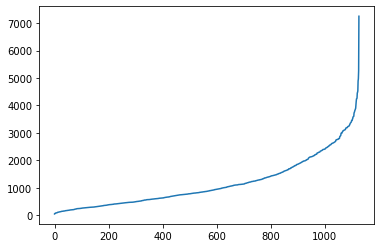

In [37]:
plt.plot(gs.groupby("tagId").relevance.sum().sort_values().values)

Каждому фильму из таблицы соответствует весь перечень доступных тэгов. Уберем те тэги, которые в среднем обладают релевантностью меньше 0.2

In [38]:
relev = gs.groupby("tagId").mean().relevance
index = relev.loc[relev<0.2].index.values
gs = gs.drop(gs.loc[gs.tagId.isin(index)].index, axis=0)

In [39]:
tags = gs.tagId.unique()

Переназначим номера тэгов

In [40]:
t_pos2id = {i+1:pos for i,pos in zip(range(len(tags)), tags)}
t_id2pos = {pos:i+1 for i,pos in zip(range(len(tags)), tags)}

In [41]:
gs.tagId = gs.tagId.apply(lambda x: t_id2pos[x])

Создадим sparse матрицу тэгов в векторном представлении

In [42]:
t_matrix = np.zeros(shape=(np.max(gs.movieId.values), np.max(gs.tagId.values)), dtype=np.float32)
t_matrix[gs.movieId.values-1, gs.tagId.values-1] = gs.relevance.values
t_matrix.shape

(10473, 199)

In [43]:
t_encoded = csr_matrix(t_matrix, dtype=np.float32)

Готово. Теперь добавим в эту матрицу  информацию о жанрах

In [44]:
g_t_encoded = np.concatenate((t_matrix, g_encoded.toarray()), axis=1)

И преобразуем в sparse

In [45]:
g_t_encoded = csr_matrix(g_t_encoded, dtype=np.float32)

# 5. Подготовка данных к обучению и тестированию

Для обучения и тестирования моделей над необходимо подготовить данные из датафреймов, создав матрицы пользователь-фильм (матрицы предпочтения), а также списки фильмов и их рейтингов для оценки точности и сходимости SVD и Implicit-ALS алгоритмов.

## 5.1. Списки фильмов и оценок

Преобразуем обучающий и тестовый датафреймы в списки фильмов и соответствующие им оценки пользователей

In [46]:
train_movies = []
train_df.groupby("userId").apply(lambda x: train_movies.append(x.movieId.values))
train_true_ratings = []
train_df.groupby("userId").apply(lambda x: train_true_ratings.append(x.rating.values))

""


In [47]:
test_movies = []
test_df.groupby("userId").apply(lambda x: test_movies.append(x.movieId.values))
test_true_ratings = []
test_df.groupby("userId").apply(lambda x: test_true_ratings.append(x.rating.values))

""


## 5.2. Матрицы предпочтений

Создание матриц предпочтений - операция относительно быстрая, но затратная с точки зрения оперативной памяти.  
Так как мне надоело смотреть в неподвижный экран своего зависшего компьютера, напишем метод, который сможет загружать сохраненные в sparse формате матрицы с диска, если они уже были сохранены.

In [48]:
import gc

def create_sparse(df, name, path="data/", ext=".npz", force=False):
    """
    Данный метод создает sparse матрицу для таблицы из user-item-rating таблицы
    """
    if name+ext in os.listdir(path):
        return scipy.sparse.load_npz(path+name+ext)
    else:
        r_matrix = np.empty(shape=(np.max(train_df.userId.values), np.max(train_df.movieId.values)), dtype=np.float32)
        r_matrix[df.userId.values-1, df.movieId.values-1] = df.rating.values
        r_matrix = csr_matrix(r_matrix, dtype=np.float32)
        gc.collect()
        scipy.sparse.save_npz(path + name, r_matrix, compressed=True)
        return r_matrix

In [49]:
train_sparse = create_sparse(train_df, "train")
test_sparse = create_sparse(test_df, "test")

In [50]:
del rating_df
del train_df
del test_df

# 6. Тестирование подходов

Для оценки важности выбора гиперпараметров при обучении моделей будем использовать алгоритм GridSearch - то есть проводить обучение для каждого возможного набора гиперпараметров. 

## 6.1. Коллаборативный подход 

### 6.1.1. SVG

Для сингулярного разложения матриц будем проводить тестирование с изменением размерности **k** матрицы **S**. Проверку на сходимость будем проводить для каждого значения **k**

Зададим список значений **k**

In [50]:
ks = [2, 3, 5, 10, 15, 20, 25, 50, 100, 200]

In [51]:
def get_auc_svd(matrix, movies, true_ratings):
    """
    Данный метод считает метрику AUC для SVD модели
    """
    # Предсказанные оценки для фильмов
    it = (i for i in range(len(movies)))
    pred_ratings = [matrix[next(it)][x-1] for x in movies]
    pred_ratings = np.array([x for ar in pred_ratings for x in ar])
    # Нормализуем от 0 до 1
    pred_ratings = (pred_ratings - pred_ratings.min())/(pred_ratings.max()-pred_ratings.min())
    
    true_ratings = np.array([x for ar in true_ratings for x in ar])>=0
    
    return roc_auc_score(true_ratings, pred_ratings)

In [52]:
results_svd = pd.DataFrame(columns=["k","trainAUC", "testAUC"])

for i, k in enumerate(ks):
    print(f"Тест №{(i+1)}\tk={k}")
    # SVD
    U, S, V = scipy.sparse.linalg.svds(train_sparse, k=k)
    Us = U.dot(np.diag(S))
    # SVD predictions
    matrix_pr = np.dot(Us, V).astype(np.float16)
    
    # Точность на обучающем наборе
    train_auc = get_auc_svd(matrix_pr, train_movies, train_true_ratings)
    print(f"Train AUC:\t{train_auc:.5f}")
    
    # Точность на тестовом наборе
    test_auc = get_auc_svd(matrix_pr, test_movies, test_true_ratings)
    print(f"Test AUC:\t{test_auc:.5f}")
    
    results_svd.loc[i] = (k, train_auc, test_auc)

Тест №1	k=2
Train AUC:	0.77549
Test AUC:	0.72001
Тест №2	k=3
Train AUC:	0.78580
Test AUC:	0.72762
Тест №3	k=5
Train AUC:	0.79377
Test AUC:	0.72562
Тест №4	k=10
Train AUC:	0.81274
Test AUC:	0.73109
Тест №5	k=15
Train AUC:	0.82456
Test AUC:	0.73182
Тест №6	k=20
Train AUC:	0.83397
Test AUC:	0.73019
Тест №7	k=25
Train AUC:	0.84099
Test AUC:	0.72781
Тест №8	k=50
Train AUC:	0.86506
Test AUC:	0.71695
Тест №9	k=100
Train AUC:	0.89543
Test AUC:	0.70144
Тест №10	k=200
Train AUC:	0.92902
Test AUC:	0.68318


In [53]:
results_svd.sort_values("testAUC")

,k,trainAUC,testAUC
9,200.0,0.929018,0.683183
8,100.0,0.895430,0.701438
7,50.0,0.865063,0.716951
0,2.0,0.775492,0.720009
2,5.0,0.793765,0.725618
1,3.0,0.785802,0.727621
6,25.0,0.840989,0.727814
5,20.0,0.833971,0.730191
3,10.0,0.812742,0.731088
4,15.0,0.824560,0.731816


#### Вывод

Гиперпараметр k (размерность матрицы S) является ключевым (и единственным) параметром данной системы.  

Из полученной таблицы видно, что наибольшая точность - **0.731816** - на тестовом наборе данных наблюдается при значении **k=15**.  

При увеличении значения параметра наблюдается сходимость модели, однако тестовая точность падает.

### 6.1.2. Implicit-ALS

In [50]:
!pip install implicit --quiet
import implicit as imp

In [55]:
def get_auc_als(model, data, movies, true_ratings):
    """
    Данный метод считает метрику AUC для ALS модели
    """
    # Предсказываем оценки
    pred = [model.rank_items(x, data, movies[x]-1) for x in range(data.shape[0])]
    
    # Сопоставляем оценки модели с номерами фильмов в movies
    pred_dict = [{(i+1):pr for i, pr in u} for u in pred]
    pred = np.array([pred_dict[i][x] for i, ar in enumerate(movies) for x in ar])
    
    # Нормализуем оценки
    pred_ratings = (pred - pred.min())/(pred.max()-pred.min())
    
    true_ratings = np.array([x for ar in true_ratings for x in ar])>=0
    
    return roc_auc_score(true_ratings, pred_ratings)

Протестирум модель с разными гиперпараметрами. Проверку на сходимость будем проводить для каждого набора параметров

In [56]:
factors = [8,16,32,64]
regularizations = [0, 0.01, 0.1]
iterations = [10,20,30]

In [57]:
results_als = pd.DataFrame(columns=["factors", "regularization", "iterations", "trainAUC", "testAUC"])
i = 0

for f in factors:
    for reg in regularizations:
        for it in iterations:
            print(f"Тест №{(i+1)}\tfactors={f}\tregularization={reg}\titerations={it}")
            # Обучаем модель
            model = imp.als.AlternatingLeastSquares(factors=f, regularization=reg, iterations=it)
            model.fit(train_sparse.T)

            # Точность на обучающем наборе
            train_auc = get_auc_als(model, train_sparse, train_movies, train_true_ratings)
            print(f"Train AUC:\t{train_auc:.5f}")

            # Точность на тестовом наборе
            test_auc = get_auc_als(model, test_sparse, test_movies, test_true_ratings)
            print(f"Test AUC:\t{test_auc:.5f}")

            results_als.loc[i] = (f, reg, it, train_auc, test_auc)
            i+=1

Тест №1	factors=8	regularization=0	iterations=10



Train AUC:	0.71348
Test AUC:	0.62616
Тест №2	factors=8	regularization=0	iterations=20



Train AUC:	0.71335
Test AUC:	0.62671
Тест №3	factors=8	regularization=0	iterations=30



Train AUC:	0.71335
Test AUC:	0.62671
Тест №4	factors=8	regularization=0.01	iterations=10



Train AUC:	0.71337
Test AUC:	0.62642
Тест №5	factors=8	regularization=0.01	iterations=20



Train AUC:	0.71335
Test AUC:	0.62670
Тест №6	factors=8	regularization=0.01	iterations=30



Train AUC:	0.71335
Test AUC:	0.62671
Тест №7	factors=8	regularization=0.1	iterations=10



Train AUC:	0.71161
Test AUC:	0.62411
Тест №8	factors=8	regularization=0.1	iterations=20



Train AUC:	0.71335
Test AUC:	0.62670
Тест №9	factors=8	regularization=0.1	iterations=30



Train AUC:	0.71335
Test AUC:	0.62671
Тест №10	factors=16	regularization=0	iterations=10



Train AUC:	0.73466
Test AUC:	0.62921
Тест №11	factors=16	regularization=0	iterations=20



Train AUC:	0.73595
Test AUC:	0.63156
Тест №12	factors=16	regularization=0	iterations=30



Train AUC:	0.73548
Test AUC:	0.63112
Тест №13	factors=16	regularization=0.01	iterations=10



Train AUC:	0.73594
Test AUC:	0.63010
Тест №14	factors=16	regularization=0.01	iterations=20



Train AUC:	0.73592
Test AUC:	0.63069
Тест №15	factors=16	regularization=0.01	iterations=30



Train AUC:	0.73579
Test AUC:	0.63149
Тест №16	factors=16	regularization=0.1	iterations=10



Train AUC:	0.73530
Test AUC:	0.63024
Тест №17	factors=16	regularization=0.1	iterations=20



Train AUC:	0.73565
Test AUC:	0.63165
Тест №18	factors=16	regularization=0.1	iterations=30



Train AUC:	0.73558
Test AUC:	0.63137
Тест №19	factors=32	regularization=0	iterations=10



Train AUC:	0.76036
Test AUC:	0.62919
Тест №20	factors=32	regularization=0	iterations=20



Train AUC:	0.76074
Test AUC:	0.63006
Тест №21	factors=32	regularization=0	iterations=30



Train AUC:	0.76067
Test AUC:	0.62957
Тест №22	factors=32	regularization=0.01	iterations=10



Train AUC:	0.76017
Test AUC:	0.62865
Тест №23	factors=32	regularization=0.01	iterations=20



Train AUC:	0.76060
Test AUC:	0.62949
Тест №24	factors=32	regularization=0.01	iterations=30



Train AUC:	0.76061
Test AUC:	0.62923
Тест №25	factors=32	regularization=0.1	iterations=10



Train AUC:	0.76039
Test AUC:	0.62897
Тест №26	factors=32	regularization=0.1	iterations=20



Train AUC:	0.76082
Test AUC:	0.63006
Тест №27	factors=32	regularization=0.1	iterations=30



Train AUC:	0.76057
Test AUC:	0.62895
Тест №28	factors=64	regularization=0	iterations=10



Train AUC:	0.79245
Test AUC:	0.61785
Тест №29	factors=64	regularization=0	iterations=20



Train AUC:	0.79267
Test AUC:	0.61712
Тест №30	factors=64	regularization=0	iterations=30



Train AUC:	0.79293
Test AUC:	0.61718
Тест №31	factors=64	regularization=0.01	iterations=10



Train AUC:	0.79273
Test AUC:	0.61755
Тест №32	factors=64	regularization=0.01	iterations=20



Train AUC:	0.79289
Test AUC:	0.61738
Тест №33	factors=64	regularization=0.01	iterations=30



Train AUC:	0.79296
Test AUC:	0.61741
Тест №34	factors=64	regularization=0.1	iterations=10



Train AUC:	0.79250
Test AUC:	0.61830
Тест №35	factors=64	regularization=0.1	iterations=20



Train AUC:	0.79291
Test AUC:	0.61740
Тест №36	factors=64	regularization=0.1	iterations=30



Train AUC:	0.79304
Test AUC:	0.61711


In [58]:
results_als.sort_values("testAUC")

,factors,regularization,iterations,trainAUC,testAUC
35,64.0,0.10,30.0,0.793037,0.617109
28,64.0,0.00,20.0,0.792673,0.617124
29,64.0,0.00,30.0,0.792933,0.617183
31,64.0,0.01,20.0,0.792892,0.617383
34,64.0,0.10,20.0,0.792907,0.617403
32,64.0,0.01,30.0,0.792964,0.617412
30,64.0,0.01,10.0,0.792734,0.617547
27,64.0,0.00,10.0,0.792446,0.617850
33,64.0,0.10,10.0,0.792501,0.618303
6,8.0,0.10,10.0,0.711609,0.624110


#### Вывод

Так же, как и в случае с SVD моделью, сходимость растет по мере увеличения размерности скрытого пространства - значения параметра **f**.  

При этом, максимального значения точности - **0.631646** - на тестовой выборке модель достигает при значении **f=16**.

Регуляризация незначительно влияет на сходимость в данной модели.

### 6.1.3. Baseline LightFM

Для тестирования моделей с коллаборативным и с гибридным подходом отлично подходит библиотека LightFM. Воспользуемся ей для тестирования коллаборативного подхода.

In [51]:
!pip install lightfm --quiet
from lightfm import LightFM
from lightfm.evaluation import auc_score

In [91]:
def testLightFM(n_c=10, epochs=50, lr=0.005, loss="warp", item_features=None, verbose=False):
    """
    Данный метод обучает модель LightFM с заданными гиперпараметрами и возвращает информацию о наилучшей точности  
    """
    model = LightFM(no_components=n_c, loss=loss, learning_rate=lr)
    print("Epoch\tTrain\tTest")
    best = (0, 0, 0)
    tr_auc = 0
    ts_auc = 0
    for i in range(epochs):
        # Обучиться в течении одной эпохи
        model.fit_partial(train_sparse, epochs=1, verbose=verbose, num_threads=6, item_features=item_features)
        # Провести тестирование
        if (i+1)%5==0:
            tr_auc = auc_score(model, train_sparse, num_threads=6, item_features=item_features).mean()
            ts_auc = auc_score(model, test_sparse, num_threads=6, item_features=item_features).mean()
            print(f"{(i+1)}  \t{tr_auc:.5f}\t{ts_auc:.5f}")
        else:
            ts_auc = auc_score(model, test_sparse, num_threads=6, item_features=item_features).mean()
            print(f"{(i+1)}  \t\t{ts_auc:.5f}")
        
        if ts_auc>best[2]:
            best = (i, tr_auc, ts_auc)
            
    return best

Протестирум модель с разными гиперпараметрами. Проверку на сходимость будем проводить раз в 5 эпох, поскольку это очень затратная по времени операция

Была выбрана функция ошибки *warp*, поскольку она стабильно показывает лучшие результаты.

In [65]:
learning_rate = [0.05,0.005]
n_components = [16, 32, 64]
epochs = 25

In [66]:
results_LFM_base = pd.DataFrame(columns=["learning_rate", "n_components", "epoch", "trainAUC", "testAUC"])

i = 0

for lr in learning_rate:
    for n_c in n_components:
        print(f"Тест №{(i+1)}\tlearning rate={lr}\tnumber of components={n_c}")
        ep, train_auc, test_auc = testLightFM(lr=lr, n_c=n_c, epochs=epochs)
        results_LFM_base.loc[i] = (lr, n_c, ep, train_auc, test_auc)
        i+=1
        print()

Тест №1	learning rate=0.05	number of components=16
Epoch	Train	Test
1  		0.91567
2  		0.92224
3  		0.92563
4  		0.92773
5  	0.95549	0.92918
6  		0.93025
7  		0.93111
8  		0.93181
9  		0.93238
10  	0.95856	0.93287
11  		0.93329
12  		0.93364
13  		0.93395
14  		0.93422
15  	0.96001	0.93446
16  		0.93467
17  		0.93487
18  		0.93503
19  		0.93520
20  	0.96086	0.93534
21  		0.93546
22  		0.93557
23  		0.93567
24  		0.93578
25  	0.96145	0.93586

Тест №2	learning rate=0.05	number of components=32
Epoch	Train	Test
1  		0.91962
2  		0.92621
3  		0.92920
4  		0.93099
5  	0.95853	0.93223
6  		0.93315
7  		0.93388
8  		0.93443
9  		0.93489
10  	0.96149	0.93525
11  		0.93554
12  		0.93576
13  		0.93597
14  		0.93616
15  	0.96279	0.93631
16  		0.93643
17  		0.93654
18  		0.93662
19  		0.93669
20  	0.96351	0.93678
21  		0.93683
22  		0.93689
23  		0.93692
24  		0.93694
25  	0.96394	0.93696

Тест №3	learning rate=0.05	number of components=64
Epoch	Train	Test
1  		0.92229
2  		0.92872
3  		0.93157
4  

In [67]:
results_LFM_base.sort_values("testAUC")

,learning_rate,n_components,epoch,trainAUC,testAUC
4,0.005,32.0,24.0,0.934353,0.894220
3,0.005,16.0,24.0,0.934535,0.894829
5,0.005,64.0,24.0,0.940881,0.904577
0,0.050,16.0,24.0,0.961445,0.935860
2,0.050,64.0,14.0,0.965074,0.936662
1,0.050,32.0,24.0,0.963935,0.936962


#### Вывод

Модель LightFM показала самые высокие значения точности как на обучающем (**0.963935**), так и на тестовом (**0.936962**) наборах данных. Полагаю, это связано с внутренней реализацией модели. В частности, с наличием оптимизационного алгоритма *Adagrad*.

В случае с данной моделью, результаты обучения практически не зависят от размерности скрытого пространства - модель демонстрирует высокие показатели точности для всех выбранных значений размерности.  

Возможно, модель способна показать лучшие результаты при дополнительном обучении.

## 6.2. Гибридный (Коллаборативный + Контентный) подход

### 6.2.1. LightFM + genres

При обучении данной модели воспользуемся информацией о жанрах фильмов. Списки гиперпараметров оставим без изменений.

In [68]:
results_LFM_genres = pd.DataFrame(columns=["learning_rate", "n_components", "epoch", "trainAUC", "testAUC"])

i = 0

for lr in learning_rate:
    for n_c in n_components:
        print(f"Тест №{(i+1)}\tlearning rate={lr}\tnumber of components={n_c}")
        ep, train_auc, test_auc = testLightFM(lr=lr, n_c=n_c, item_features=g_encoded, epochs=epochs)
        results_LFM_genres.loc[i] = (lr, n_c, ep, train_auc, test_auc)
        i+=1
        print()

Тест №1	learning rate=0.05	number of components=16
Epoch	Train	Test
1  		0.64535
2  		0.64737
3  		0.64831
4  		0.64839
5  	0.70078	0.64844
6  		0.64822
7  		0.64785
8  		0.64738
9  		0.64689
10  	0.70547	0.64658
11  		0.64626
12  		0.64578
13  		0.64544
14  		0.64523
15  	0.70720	0.64470
16  		0.64458
17  		0.64419
18  		0.64387
19  		0.64373
20  	0.70833	0.64341
21  		0.64308
22  		0.64294
23  		0.64269
24  		0.64248
25  	0.70910	0.64247

Тест №2	learning rate=0.05	number of components=32
Epoch	Train	Test
1  		0.64934
2  		0.65042
3  		0.64992
4  		0.64911
5  	0.70919	0.64789
6  		0.64688
7  		0.64586
8  		0.64466
9  		0.64376
10  	0.71405	0.64298
11  		0.64202
12  		0.64141
13  		0.64059
14  		0.64001
15  	0.71534	0.63924
16  		0.63866
17  		0.63815
18  		0.63773
19  		0.63721
20  	0.71593	0.63679
21  		0.63647
22  		0.63611
23  		0.63557
24  		0.63521
25  	0.71612	0.63513

Тест №3	learning rate=0.05	number of components=64
Epoch	Train	Test
1  		0.65239
2  		0.65193
3  		0.65005
4  

In [69]:
results_LFM_genres.sort_values("testAUC")

,learning_rate,n_components,epoch,trainAUC,testAUC
0,0.050,16.0,4.0,0.700782,0.648437
1,0.050,32.0,1.0,0.000000,0.650417
3,0.005,16.0,24.0,0.693705,0.651902
2,0.050,64.0,0.0,0.000000,0.652390
4,0.005,32.0,24.0,0.698395,0.652982
5,0.005,64.0,22.0,0.702092,0.653616


#### Вывод

Модель LightFM с добавлением информации о жанрах фильмов, закодированной в векторном представлении, отработала значительно хуже, чем та же модель без дополнительной информации о фильмах. 

Полученные максимальные значения точности - **0.702092** на обучающем и **0.653616** на тестовом наборе - демонстрируют низкую сходимость модели. Я связываю это с тем, что, возможно, векторное представление фильмов в модели слабо соотносится с векторным представлением жанров фильмов, что вызывает трудности при обучении.

### 6.2.2. LightFM + tags

При обучении данной модели воспользуемся информацией о тэгах фильмов. Списки гиперпараметров оставим без изменений.

In [70]:
results_LFM_tags = pd.DataFrame(columns=["learning_rate", "n_components", "epoch", "trainAUC", "testAUC"])

i = 0

for lr in learning_rate:
    for n_c in n_components:
        print(f"Тест №{(i+1)}\tlearning rate={lr}\tnumber of components={n_c}")
        ep, train_auc, test_auc = testLightFM(lr=lr, n_c=n_c, item_features=t_encoded, epochs=epochs)
        results_LFM_tags.loc[i] = (lr, n_c, ep, train_auc, test_auc)
        i+=1
        print()

Тест №1	learning rate=0.05	number of components=16
Epoch	Train	Test
1  		0.86231
2  		0.86759
3  		0.87063
4  		0.87217
5  	0.90934	0.87326
6  		0.87424
7  		0.87492
8  		0.87530
9  		0.87588
10  	0.91254	0.87607
11  		0.87644
12  		0.87647
13  		0.87674
14  		0.87688
15  	0.91399	0.87704
16  		0.87723
17  		0.87730
18  		0.87733
19  		0.87752
20  	0.91478	0.87750
21  		0.87732
22  		0.87754
23  		0.87756
24  		0.87780
25  	0.91519	0.87758

Тест №2	learning rate=0.05	number of components=32
Epoch	Train	Test
1  		0.86720
2  		0.87221
3  		0.87428
4  		0.87529
5  	0.91399	0.87593
6  		0.87634
7  		0.87681
8  		0.87667
9  		0.87676
10  	0.91631	0.87689
11  		0.87671
12  		0.87675


KeyboardInterrupt: 

In [71]:
results_LFM_tags.sort_values("testAUC")

,learning_rate,n_components,epoch,trainAUC,testAUC
0,0.05,16.0,23.0,0.914776,0.877805


#### Вывод

Тестирование пришлось прервать предварительно, поскольку на обучение и тестирование для одной одной эпохи уходило 15 минут реального времени.

Однако, модель LightFM с добавлением данных о тэгах фильмов показала значительно лучшие результаты, чем та же модель с добавлением информации о жанрах - **0.914776** на обучающем и **0.877805** на тестовом наборе. Это говорит о том, что тэги, возможно, содержит в себе дополнительную информацию о каждом фильме, для изъятия которой может потребоваться увеличить продолжительность обучения.

Кроме того, было бы интересно проверить дальнейшую сходимость модели при различных гиперпараметрах (если бы обучение не занимало так долго).

# 7. Вывод

## 7.1. Общие выводы

В результате проведенного исследования были получены следующие показатели метрики ROC AUC для моделей

**Коллаборативный подход**
1. *LightFM - 0.963935 - 0.936962*
2. SVD - 0.824560 - 0.731816
3. Implicit-ALS - 0.735655 - 0.631646

**Гибридный подход**

1. *LightFM+tags - 0.914776 - 0.877805*
2. LightFM+genres - 0.702092 - 0.653616


Для коллаборативного подхода самой успешной моделью, согласно метрике AUC, стала модель LightFM с параметрами *n_components=32* и *learning_rate=0.05*.  

Для гибридного подхода наибольшего успеха достигла модель LightFM+tags с параметрами *n_components=16* и *learning_rate=0.05*. 

Наилучших показателей метрики среди всех моделей достигла модель LightFM с использование коллаборативного подхода. 

## 7.2. Оценка статистической значимости


### 7.2.1. Подготовка

Для оценки статистической значимости использования получившихся моделей для бинарной классификации воспользуемся тестом МакНемара и уровнем значимости альфа 0.01.

In [83]:
alpha = 0.01

In [71]:
!pip install mlxtend --quiet
!pip install statsmodels --quiet
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.plotting import checkerboard_plot
from mlxtend.evaluate import mcnemar_table

Поскольку я не сохранил модели, пришлось заново написать методы для рассчета оценок, взяв наилучшие значения параметров для каждой сети. Установим порог решающего правила 0.5

In [65]:
def svd_pred_ratings(k=15):
    """
    Данный метод возвращает оценки фильмов, предсказанные с помощью модели SVD  
    """
    # SVD разложение
    U, S, V = scipy.sparse.linalg.svds(train_sparse, k=15)
    Us = U.dot(np.diag(S))
    
    # SVD матрица
    matrix_pr = np.dot(Us, V).astype(np.float16)
    it = (i for i in range(len(test_movies)))
    # Преобразуем в векторный вид
    pred_ratings = [matrix_pr[next(it)][x-1] for x in test_movies]
    del matrix_pr
    pred_ratings = np.array([x for ar in pred_ratings for x in ar])
    # Нормируем
    pred_ratings = (pred_ratings - pred_ratings.min())/(pred_ratings.max()-pred_ratings.min())
    pred_ratings = (pred_ratings>=0.5).astype(int)
    
    return pred_ratings

In [66]:
def als_pred_ratings(fc=16, rg=0.10, it=20):
    """
    Данный метод возвращает оценки фильмов, предсказанные с помощью модели Implicit-ALS  
    """
    # Обучим модель
    model = imp.als.AlternatingLeastSquares(factors=fc, regularization=rg, iterations=it)
    model.fit(train_sparse.T)
    pred = [model.rank_items(x, test_sparse, test_movies[x]-1) for x in range(test_sparse.shape[0])]

    # Сопоставляем оценки модели с номерами фильмов в movies
    pred_dict = [{(i+1):pr for i, pr in u} for u in pred]
    pred = np.array([pred_dict[i][x] for i, ar in enumerate(test_movies) for x in ar])

    # Нормализуем оценки
    pred_ratings = (pred - pred.min())/(pred.max()-pred.min())
    pred_ratings = (pred_ratings>=0.5).astype(int)
    
    return pred_ratings

In [93]:
def lightfm_pred_ratings(n_c=32, loss="warp", lr=0.05, epochs=25, item_features=None):
    """
    Данный метод возвращает оценки фильмов, предсказанные с помощью модели LightFM  
    """
    # Обучим модель
    model = LightFM(no_components=n_c, loss=loss, learning_rate=lr)
    model.fit(train_sparse, epochs=epochs, verbose=True, num_threads=6, item_features=item_features)
    # Предскажем значения
    pred_ratings = np.array([model.predict(x, test_movies[x]-1, item_features=item_features, num_threads=6)\
                             for x in range(test_sparse.shape[0])]).ravel()
    pred_ratings = (pred_ratings>0).ravel()
    
    return pred_ratings

Переведем таблицу верных оценок в векторный формат

In [68]:
true_ratings = np.array([x for ar in test_true_ratings for x in ar])>=0

Найдем оценки для каждого из подходов. В качестве baseline возьмем случайный вектор, выбранный из нормального распределения.

In [78]:
baseline = (np.random.normal(size=(len(true_ratings)))>0).astype(int)

svd_pred = svd_pred_ratings()
als_pred = als_pred_ratings()
lfm_pred = lightfm_pred_ratings()
lfm_g_pred = lightfm_pred_ratings(n_c=64, lr=0.005, item_features=g_encoded)

Epoch: 100%|██████████| 25/25 [08:21<00:00, 20.06s/it]


На полное повторное обучение модели LightFM+tags не остается времени, поэтому установим длительность ее обучения в 1 эпоху

In [100]:
lfm_t_pred = lightfm_pred_ratings(n_c=16, lr=0.05, item_features=t_encoded, epochs=1)

Epoch: 100%|██████████| 1/1 [04:14<00:00, 254.56s/it]


### 7.2.2. Оценка и ранжирование

Проведем попарную оценку статистической значимости между моделями, а также выведем их ранжирование между собой на экран.

In [103]:
pred_dict = dict(zip(("baseline", "svd", "als", "lfm", "lfmg", "lfmt"),\
                     [baseline,svd_pred,als_pred,lfm_pred,lfm_g_pred, lfm_t_pred]))
pred_range = dict(zip(("baseline", "svd", "als", "lfm", "lfmg", "lfmt"), np.zeros(shape=6)))

In [104]:
results = pd.DataFrame(index=list(pred_dict.keys()), \
                       columns=list(pred_dict.keys()), dtype=str)

for i, m1 in enumerate(list(pred_dict.keys())):
    for j, m2 in enumerate(list(pred_dict.keys())):
        table = mcnemar_table(true_ratings, pred_dict[m1], pred_dict[m2])
        results.iloc[i,j] = mcnemar(table).pvalue < alpha
        if m1!=m2:
            if table[0,1]>table[1,0]:
                pred_range[m1] += 1
            elif table[0,1]<table[1,0]:
                pred_range[m2] += 1
            else:
                pred_range[m1] += 1
                pred_range[m2] += 1
            #print(f"{m1} better than {m2}" if table[0,1]>table[1,0] else f"{m1} worse than {m2}" )
print(pred_range)
print(" > ".join(dict(sorted(pred_range.items(), key=lambda item: item[1], reverse=True)).keys()))
results

{'baseline': 2.0, 'svd': 6.0, 'als': 0.0, 'lfm': 8.0, 'lfmg': 4.0, 'lfmt': 10.0}
lfmt > lfm > svd > lfmg > baseline > als


,baseline,svd,als,lfm,lfmg,lfmt
baseline,False,True,True,True,True,True
svd,True,False,True,True,True,True
als,True,True,False,True,True,True
lfm,True,True,True,False,True,True
lfmg,True,True,True,True,False,True
lfmt,True,True,True,True,True,False


Из полученного вывода видно, что увеличение частоты правильных ответов между всеми парами моделей статистически значимо.   

Это значит, что в получившейся ранжировке моделей, изменения в точности между любыми двумя моделями также статистически значимо.

Итоговая ранжировка моделей по точности:  

**LFM+T(hybrid) > LFM(colab) > SVD(colab) > LFM+G(hybrid) > Baseline > ALS(colab)**

Примечательно, что при пороговом значении в 0.5, модель LFM+T демонстрирует статистически значимо лучшие показатели точности, чем LFM модель, хоть AUC score модели LFM превышает score LFM+T.  

Это говорит о том, что в целом модель LFM показывает лучшие результаты при различных пороговых значениях, однако именно при 0.5 LFM+T лучше. 